# Homework 5 Coding Assignment: Deep Q-learning

In this assignment, we will explore the deep Q-learning algorithm in depth, covering important concepts such as the Bellman equation, double Q networks, memory replay mechanisms, exploration-exploitation trade-offs, and Temporal Difference Loss. To help you get a better sense of the interaction between an intelligent agent and its environment, we will be using the popular Gym library and saving the game as a video. This will allow you to see firsthand how your agent evolves and improves over the course of the training process.

**Before Training:**

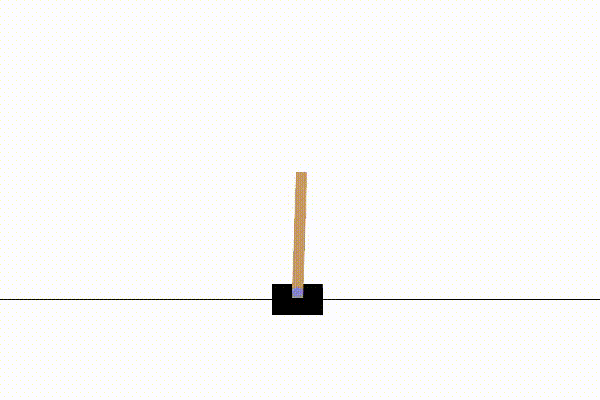

**After Training:**

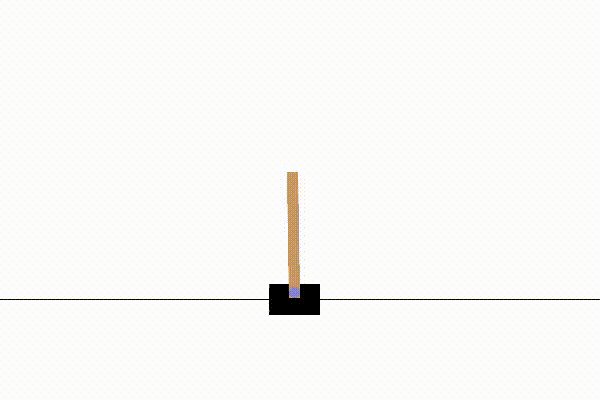

To get started, you'll need to install the required dependencies and set up your environment. Once you've done that, you can dive into the code and start experimenting with different hyperparameters and settings to see how they affect the performance of your agent. We encourage you to be creative and try out new ideas, as this will help you develop a deeper understanding of the algorithm and its capabilities.



## About Deep Q-learning

Deep Q-learning is a powerful and flexible approach to learning in complex environments, and has been successfully applied to a wide range of problems in robotics, gaming, and beyond. One of its key features is the use of neural networks as function approximators for the action-value function, Q. In this approach, the network takes the current state of the game simulator (e.g., the screen frame) as input and passes it through a carefully designed architecture before outputting a Q value for each possible action.

The neural network used in Deep Q-learning typically consists of multiple layers, including convolutional layers, pooling layers, and fully connected layers. These layers work together to learn features from the input state that are relevant for making good decisions in the game. The network is trained using a combination of supervised learning and reinforcement learning, with the goal of minimizing the difference between the predicted Q values and the true Q values.

One of the advantages of using neural networks in this way is that they can learn to generalize from the input state to similar states, even if they have not been seen before. This allows the agent to make good decisions even in situations that it has not explicitly encountered during training. However, it is important to carefully design the network architecture and training procedure to avoid issues such as overfitting and instability. 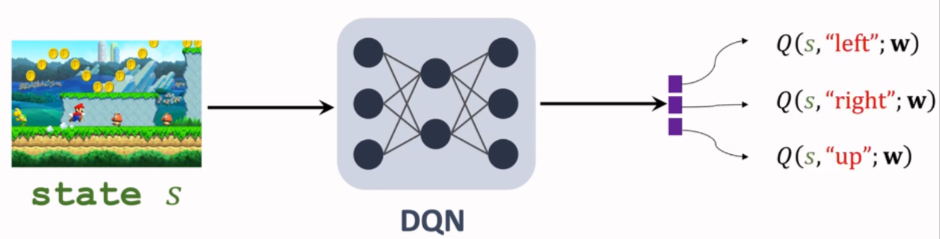

In reinforcement learning, the optimal action-value function $Q^*(s,a)$ is defined as the maximum expected return achievable by following any strategy, given that we have observed some sequence of states $s$ and then taken some action $a$.

Suppose we are in state $s$ and decide to take action $a$, which leads us to the next state $s'$. If we assume that in state $s'$ the $Q^*$-values for all possible actions $a'$ are already known, then the optimal action-value for state $s$ and action $a$ can be expressed as the reward $r$ we obtained for taking action $a$, plus the discounted maximum future return from $s'$:

\begin{equation}
Q^*(s,a) = r + \gamma E_{s'}\textrm{max}_{a'} Q^*(s',a') 
\end{equation}

Here, $\gamma$ is a discount factor that controls the relative importance of immediate and future rewards. This equation is known as the **Bellman optimality equation**, and it forms the basis for many reinforcement learning algorithms.

By iteratively updating the $Q$-values using the Bellman equation, we can learn an optimal policy that maximizes the expected return over time.   Deep Q-Learning uses a neural network to find an approximation $Q(s,a,\theta)$ of $Q^*(s,a)$, where $\theta$ are the parameters of the neural network.

## Install packages

In [ ]:
!apt-get update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet


Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [77.6 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,668 kB]
Get:14 http://securi

## Import Libraries

In [ ]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
import os
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40)
from tqdm import tqdm
import matplotlib
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Preparing Video Saving

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
    env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
    return env


## Cuda

In [ ]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

## Building Environment

In this assignment, we will develope our agent playing CartPole, which is a classical environment in reinforcement learning. You may find more information about the environment [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)

In [ ]:
env_id = "CartPole-v1"
env = gym.make(env_id)
env = wrap_env(env)

## Memory Replay

Memory replay is a crucial component of off-policy deep reinforcement learning algorithms, improving the sample efficiency and stability of training by storing the previous environment interactions experienced by an agent.

**Task 1**: Please explain in detail how memory replay will help with improving reinforcement learning algorithms. 

ANSWER: When using a neural network for supervised learning, there is an assumption of independent and identically distributed (i.d.d) data samples, which is not met when samples come a sequential experience. The samples are highly correlated to each other in which causes the learning to be instable. By using memory replay, all sequential experience are stored in a buffer which at each time step a difference experience is chosen. This way somewhat independent samples are chosen at each time step which makes samples not as correlated to each other, though there might be some correlation due to the dynamics of the environment. This leads to a stable learning process. 

Also, the memory replay proves to be more effecient since one experience has a chance of being used multiple times before it is discarded or forgotten. This makes the learning process use lesser samples than without a replay buffer.

Memory replay is an important technique for improving reinforcement learning algorithms, and it involves storing an agent's experiences in a circular, first-in-first-out (FIFO) replay buffer. This buffer acts as a kind of database, allowing the agent to learn from past experiences and avoid the pitfalls of only considering its most recent interactions with the environment.

To implement memory replay, we need to store several pieces of information for each interaction with the environment, including the current state, the action taken, the resulting reward, and the next state. By doing so, we can build up a rich dataset of experiences that the agent can use to learn from over time.

In the following section, we will take a closer look at how the memory replay buffer is constructed and test its effectiveness in improving the performance of our reinforcement learning algorithm. We encourage you to pay close attention to the details of the implementation and experiment with different settings to see how they affect the learning process.



In [ ]:
# In this part, we used depue object from collections in python to generate a buffer
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)                            # Initialization of the buffer of capacity given by the input of the function,' capacity'
    def push(self, state, action, reward, next_state, done):            # Store one single experience (state, action, reward, next_state, done flag) in the buffer
        state      = np.expand_dims(state, 0)                           # If you want to push an experience to the buffer, you have to make sure the 'state' and 'next_state' is 3-dimensional array
        next_state = np.expand_dims(next_state, 0)                      # 'action' and 'reward' are two scalars, the 'done' is 'False' or 'True'
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))    # This method will return you a batch of experiences
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    def __len__(self):                  
        return len(self.buffer)                       # This method return the length of the buffer

**Task 2:** As part of this assignment, you will be testing the effectiveness of the memory replay buffer. To do so, you will need to push the trajectory generated into the 'test_buffer' and then sample 2 experiences from the buffer at random. The experience is just a tuple of (state, action, reward, next_state, done).  

Once you have done this, please copy your output into your solution file and specify what the experiences are in terms of the action taken, the reward received, whether the episode is complete (i.e. done), the current state, and the next state.

In [ ]:
# Test Case for Task 2:
# In this task, we are going to look into memory replay machenism, and we will understand how the experiences are stored in the buffer and how to sample experiences from the buffer.
# In this part, we used the loop to generate 10 experiences randomly, and we want to you to put these experiences into buffer iteratively.
# After the loop, you will need to sample 2 experiences from buffer randomly, and report them in your solution file
# To finish this part, please pay attention to the previous code cell and try to understand how the data is stored in the buffer
test_buffer = ReplayBuffer(10)
for i in range(10):
    action = np.random.randint(2,5)
    reward = np.random.randint(5,10)
    done = np.random.randint(0,2)
    state = np.random.randint(10,20, size=(4,1))
    next_state = np.random.randint(20,30, size=(4,1))
    ## student code here
    test_buffer.push(state, action, reward, next_state, done)
                 # push the experience into buffer, as a hint, you may use the method .push() defined above to push the experience to buffer
samples = test_buffer.sample(2)                                           # after pushing all experiences, sample 2 experiences. You can use .sample() method to sample 2 experiences from buffer
## student code end
print('Samples: ', samples)
# The result should be a tuple, each element corresponds to an item in experience, and it is a array containing all items in the batch.
# Here is an example output: 
#Samples:  (array([[[10],
#        [17],
#        [10],
#        [18]],
#
#       [[17],
#        [14],
#        [12],
#        [12]]]), (2, 3), (7, 8), array([[[21],
#        [23],
#        [25],
#        [26]],
#
#       [[23],
#        [25],
#        [21],
#        [29]]]), (0, 1))

Samples:  (array([[[10],
        [12],
        [16],
        [11]],

       [[13],
        [15],
        [18],
        [19]]]), (2, 2), (9, 5), array([[[28],
        [28],
        [24],
        [21]],

       [[23],
        [27],
        [24],
        [22]]]), (1, 0))


In [ ]:
# define the buffer
replay_buffer = ReplayBuffer(1000)      # Here we define a buffer of capacity 1000, which means we will store at most 1000 newest experiences

<h2>Deep Q Network</h2>

Deep Q-Learning is a powerful extension of the Q-learning algorithm that replaces the traditional Q-table with a neural network. This network is designed to map input states to (action, Q-value) pairs, rather than simply storing the Q-values in a lookup table.

As illustrated in the figure below, the Q-network takes the current state as input and produces a set of Q-values, one for each possible action. The action with the highest Q-value is then selected as the next action during the exploitation phase of the algorithm.

This approach has several advantages over traditional Q-learning, including the ability to handle high-dimensional state spaces and to generalize from previously unseen states. However, it also introduces some additional complexity in terms of designing and training the neural network effectively.

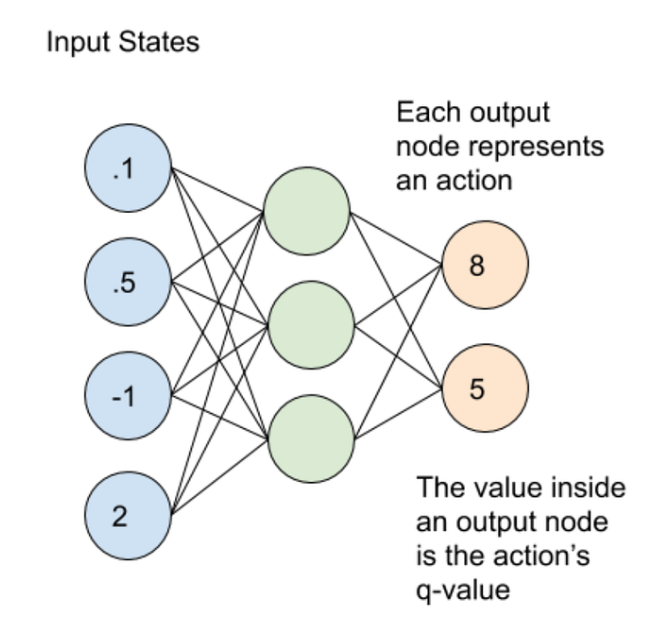

**Task 3:** Build a neural network mapping states to actions in the following blank. Attach screenshot of your code to your solution file. Check your result in test case and put the screenshot to your solution file.

You may find more information about the environment [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)

In [ ]:
# In this part, we are going to implement a quite basic neural network using pytorch. 
# The dimension and profile of the Q-network is crucial to the final performance, therefore we will provide some specific suggestions:
# Suggestions: 2-5 fully connected layers, less than 512 neurons per layer
# The training time, or say computational complexity directly depend on the scale of the network, which means you may want to find a balance between performance and complexity
class DQN(nn.Module):                                                         # We build our neural network using nn.Module class in pytorch, you may find some examples at https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self, num_actions):                                          # 'num_action' is the number of all possible actions in the environment. Each action corresponds to one bit output of neural network. If we have 'num_action' actions, the output shape of the neural network should be 'num_action' by 1.
        super(DQN, self).__init__()
        ## student code here
        self.layers = nn.ModuleList([nn.Linear(4, 500), nn.Linear(500, 500), nn.Linear(500, 500), nn.Linear(500, 2)])             # In this part, you need to define your network layer by layer, here is an great example showing how to implement: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
        # self.layers = nn.ModuleList([nn.Linear(4, 100), nn.Linear(100, 100), nn.Linear(100, 2)])    
        ## student code end
    def forward(self, x):                                                     # With the network defined, we have to define the forwarding method for the neural network, within which input data will be forwarded in the order of your defined layers, and you need to return final output
        ## student code here
        for layer in self.layers:
          x = layer(x)
          x = nn.functional.relu(x)
                                          # define forward procedure of your network
        return  x            # Return the output of the network. It should be the same dimension with action space 
        ## student code end


In [ ]:
# Test Case of Task 3
Test_DQN = DQN(10)
state = env.reset()
action_value = Test_DQN.forward(torch.FloatTensor(state))
print('The Q value for each action:', action_value.data.numpy())
# The output should be a vector consists of 2 Q values for action0 and action1. Below is an example:
# The Q value for each action: [0.05737116 0.07451424]

The Q value for each action: [0.01682857 0.        ]


## Evaluate Network and Target Network

The Bellman equation provides us with the value of $Q(s, a)$ via $Q(s', a')$. However, when the two states, $s$ and $s'$, are close together (i.e., only one step apart), they can be very similar, making it difficult for a neural network to distinguish between them. This can lead to instability in the training process, as updates to one state can indirectly affect the value of nearby states.

To address this issue and improve the stability of the training process, we can use a technique known as a target network. The basic idea is to maintain a copy of our neural network, called the target network, and use it to generate the $Q(s', a')$ values in the Bellman equation.

During training, we use the predicted $Q$ values from the target network to backpropagate and update the main Q-network's parameters. It's important to note that the target network's parameters are not trained directly, but are periodically synchronized with the parameters of the main Q-network. By using the target network's $Q$ values to train the main Q-network, we can improve the stability of the training process and prevent the propagation of errors through the network.

In [ ]:
# WARNING: Due to the feature of ipython notebook, please rerun this cell before every time running main training cell, because we need to initialize the network before retraining it
eval_model = DQN(env.action_space.n)
target_model  = DQN(env.action_space.n)

if USE_CUDA:
    eval_model = eval_model.cuda()
    target_model  = target_model.cuda()

optimizer = optim.Adam(eval_model.parameters(), lr= 0.001)

<h2>Epsilon greedy exploration</h2>

The epsilon-greedy method is a simple approach to balancing exploration and exploitation in reinforcement learning. This method involves randomly choosing between exploration and exploitation, with the probability of exploration given by the parameter epsilon.

During exploitation, we select actions based on the current neural network's Q-values, while during exploration, we choose actions randomly. By randomly choosing between these two modes of operation, we can strike a balance between exploiting our current knowledge and exploring new possibilities.

Typically, we choose a small value of epsilon (e.g., 0.1) to ensure that we still explore new actions occasionally, even when we have a lot of information about the environment. As we train the neural network and gather more data, we can gradually decrease epsilon over time to focus more on exploitation.

**Task 4:** Finish following function to return actions based on Epsilon greedy policy. Attach screenshot of your code to your solution file. Check your result in test case and put the screenshot to your solution file.

In [ ]:
# In this task, your are going to design epsilon-greedy policy. 
# The input of function the state and expected epsilon
# Epsilon is the probability of taking actions randomly
# Hint: you will compose to different strategies: taking action randomly & take action from Q-network; Every time you call this function with a certain epsilon, this function will choose one of the strategies with probability epsilon.
# Output: the output should be a integer, the index of the action in action space
def choose_action(state, epsilon):
    state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True) 
    ## student code here
    if random.uniform(0,1)>epsilon:                                                        # We can implement exploiting here    
        q_value =  eval_model.forward(state)                            # Use .forward() method in DQN class to get the Q values of all actions
        action = torch.argmax(q_value).item()                  # Calculate the index of action with highest Q value. Hint: you can use torch.max()
    else:                                                                                 # We can implement exploring here
        action =  env.action_space.sample()                        # You can use built-in functions in Random or Numpy to generate a action index randomly
    ## student code end
    return action                                                               # Return the index of action

In [ ]:
# Test Case for Task 4
test_state = env.reset()
for i in range(10):                                       # We generate 10 actions using epsilon-greedy policy, epsilon = 0.5
    test_action = choose_action(test_state, 0.5)
    print('action ', i, 'is: ', test_action)

# The result of returned action should be an index in the range of action space's dimension. Here is an example:
# action  0 is:  1
# action  1 is:  0
# action  2 is:  1
# action  3 is:  0
# action  4 is:  1
# action  5 is:  1
# action  6 is:  1
# action  7 is:  1
# action  8 is:  0
# action  9 is:  1


action  0 is:  1
action  1 is:  0
action  2 is:  1
action  3 is:  1
action  4 is:  0
action  5 is:  1
action  6 is:  1
action  7 is:  1
action  8 is:  0
action  9 is:  0


In this training procedure, we will use the epsilon-greedy method to balance exploration and exploitation throughout the learning process. As the model becomes more familiar with the environment, we expect that the balance between exploration and exploitation will shift towards more exploitation, as we rely more on our current knowledge to make decisions.

To achieve this balance, we will gradually decrease the value of epsilon over time, which will make the model more adhesive to its decisions and potentially improve performance. By doing so, we hope to find a good balance between exploring new possibilities and exploiting our current knowledge, resulting in an agent that performs well across a variety of tasks.

**Task 5:** Design your own epsilon attenuation expression with respect to the number of training steps. Specifically, you will need to write a function called 'epsilon_by_frame(frame_idx)', which returns the attenuated value of epsilon for a given number of training steps (i.e., frame_idx).

Once you have written this function, you should attach it to your solution file and include a test figure below to show how the value of epsilon changes over time. Be sure to compare the final accumulated reward with and without epsilon attenuation and explain your findings in detail.

In [ ]:
# In this part, you will need to design a function that returns attenuated initial epsilon
# The input is the current training step. The bigger it is, the smaller the 'epsilon_current' should be.
# The output is the current epsilon of type 'float'
epsilon_initial = 1.0                # The epsilon should be 1 at the beginning        
## student code here
def epsilon_by_frame(frame_idx):       # Design your function here
  return np.exp(-frame_idx*0.0013)
## student code end

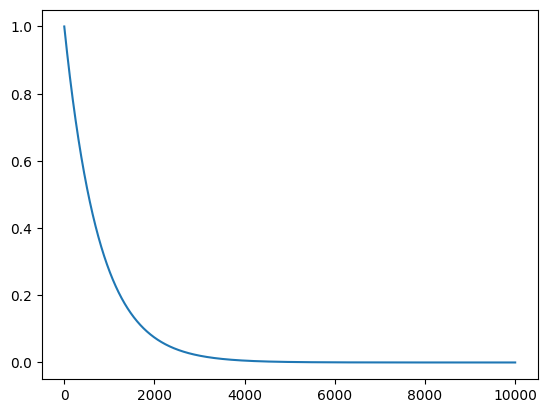

In [ ]:
# test case for task 5
plt.plot([epsilon_by_frame(i) for i in range(10000)])
# print(epsilon_by_frame(1000))
# print(epsilon_by_frame(4000))
# Check if your epsilon is decreasing along the training steps. As a suggestion, the epsilon value should be around 0.1 to 0.3 at step 1000, be around 0.05 at step 4000

 This figure should clearly illustrate how epsilon is attenuated over the course of training.

<h2>Computing Temporal Difference Loss</h2>

As a value-based method, the Q-network is used to predict the expected cumulative reward for each action $a$ under state $s$. To learn the Q-function $Q(s, a)$, we can update its parameters using either temporal difference learning or the Monte Carlo method.

The Monte Carlo method requires all trajectories to update a single step, which can be difficult to implement in some scenarios. Instead, we can calculate the temporal difference loss using the following equation:

\begin{equation}
Loss = MSE\left(Q(s_t,a_t;\theta_e) , \left(r_t + \gamma \cdot \mathop{max}\limits_{a}\ Q(s_{t+1},a;\theta_t)\right)\right)
\end{equation}

This equation reflects the difference between the predicted Q-value for the current state and action ($Q(s_t, a_t; \theta_e)$) and the estimated optimal Q-value for the next state ($r_t + \gamma \cdot \mathop{max}\limits_{a}\ Q(s_{t+1},a;\theta_t)$), which is discounted by the factor $\gamma$.

By minimizing this loss function, we can update the Q-network's parameters and improve its performance over time. 

To compute the temporal difference loss, we need to calculate two values: the evaluate value $Q(s_t,a_t;\theta_e)$ and the target value $(r_t + \gamma \cdot \mathop{max}\limits_{a}\ Q(s_{t+1},a;\theta_t))$. These values are used to update the model's parameters by minimizing the difference between them.

To implement the temporal difference method, we can randomly sample $s_t, a_t, s_{t+1}, r_t$ from the memory replay buffer, and calculate $Q(s_t,a_t;\theta_e)$ and $Q(s_{t+1},a;\theta_t)$ using the evaluate network and target network, respectively. Note that both of these vectors should have a dimension equal to the number of actions in the action space.

**Task 6:** Finish following blank to compute temporal difference loss. Attach screenshot of your code to your solution file


In [ ]:
# In this part, we will calculate the temporal difference loss
# The input is batch size, which means we need to sample a group of experiences from the buffer and calculate a loss function value based on that batch
# In the expression above, we have shown you how to clculate one single loss for each experience. Given a batch of experience, all the variables are organized in high-dimensional array, within which the first dimension is the batch size.
# You can calculate the batch-organized varibles as usual, based on the expression above. Finally, you just need to put the calculated evaluate Q value and expected Q value into pytorch built-in MSE function, or calculate the final loss function value on your own.
def compute_td_loss(batch_size, gamma):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)  # Sample from buffer

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    ## student code here (Note that we have provided some comments based on our implementation, but you do not have to follow them for yours.)

     # Calculate the expected Q value using the target network
    next_q_state_values = target_model.forward(next_state)
    next_q_values = torch.max(next_q_state_values, dim=1)[0]
    expected_q_values = reward + gamma * next_q_values * (1 - done)
    
    # Calculate the Q value using the evaluation network
    q_values = eval_model.forward(state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # Compute the loss using MSE
    loss = F.mse_loss(q_value, expected_q_values.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss
    # for i in range(done.shape[0]):
    #   if (done[i] ==False):# If s_t is non-terminal state (done==Flase), we can follow steps below to calculate the loss:
    #     q_values      =    eval_model.forward(state[i])                               # Calculate q values of using eval network with input 'state' using .forward() method
    #     next_q_values =    eval_model.forward(next_state[i])                               # Calculate q values of using eval network with input 'next_state' using .forward() method
    #     next_q_state_values =    target_model.forward(next_state[i])                         # Calculate q values of using target network with input 'next_state' using .forward() method


    #     q_value       =     q_values[action[i]]    # select the eval q values of actions been played and stored at state s_t, this is the evaluate value
    #     next_q_value =  torch.max(next_q_state_values, axis = 0)[0] # Use target network to calculate q values of actions that will be selected by eval network at state s_t+1, which is the second Q expression in the loss function above
    #     expected_q_value =  reward[i] + gamma*next_q_value         # compute the expected value, which is the whole second component in MSE()
        
    #     loss =  (q_value - expected_q_value)**2       # Calculate the loss
    # # If s_t is terminal state (done==True), we need to calculate the loss using expression mentioned above
    # elif (done[i] == True):
    #   loss =    


    #                                                                             # Calculate the loss
    # ## student code end    
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    
    # return loss

In [ ]:
# Test Case for Task 6:
test_state = np.array([0.27,1.95,-0.16,-2.29])
test_next_state = x=np.array([0.32,2.14,-0.21,-2.63])
test_action = 1
test_done = False
test_reward = 1.
for i in range(100):
    replay_buffer.push(test_state, test_action, test_reward, test_next_state, test_done)
test_loss = compute_td_loss(8, 0.9)

print('The test loss is: ', test_loss)
# The output should be a tensor less than 10 when you first run this cell
# I would suggest you to rerun previous "Evaluate Network and Target Network" cell to initialize the DQN before rerun this one, because function 'compute_td_loss' will update the parameters of DQN

The test loss is:  tensor(0.8842, grad_fn=<MseLossBackward0>)


## Synchronize current policy net and target net
The target network is a key feature of deep Q-learning that helps to improve convergence and stability during training. To implement this feature, we create two deep neural networks: one for retrieving Q-values (called θ-) and another for incorporating all updates during training (called θ).

During training, we use the θ- network to retrieve Q-values for the current state, while the θ network is updated using experience replay and the temporal difference loss. After a fixed number of updates (e.g., 100,000), we synchronize the θ- network with the θ network to temporarily fix the Q-value targets and avoid having a moving target to chase.

This approach helps to make the input and output of the network more stable, and behaves more like supervised training. Additionally, because changes to the θ network's parameters do not immediately impact the θ- network, even if the input is not perfectly independent and identically distributed (i.i.d.), the impact will not be incorrectly magnified.

**Task 7:** complete function below to update parameters from evaluate network to target network. Attach screenshot of your code to your solution file.

In [ ]:
# In this part, we will update target network using the parameters from evaluate network
# The input is the evaluate network and target network
def update_target(eval_net, target_net):
    global eval_model
    global target_model
    ## student code here
    target_net.load_state_dict(eval_net.state_dict())
    # for i in eval_net.state_dict():
    #   target_net.state_dict()[i] = i
     # Hint: You may use nn.module.load_state_dict() to update parameters. More info:https://pytorch.org/tutorials/beginner/saving_loading_models.html
    ## student code end

In [ ]:
# This function is defined to plot reward and loss curves
def plot(frame_idx, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

**Task 8:** pick batch size, gamma, NETWORK_UPDATE_PERIOD, learning rate and other hyperparameters to train the agent. Report result in your solution file and give your conclusions. Go over the training procedure carefully, and write down corresponding pseudo code in your solution file.

**WARNING**: Please rerun previous "Evaluate Network and Target Network" cell before rerun this main training cell

Game video of initial agent shown above, the accumulated reward is: 9
Training in progress ...


100%|██████████| 10000/10000 [04:55<00:00, 33.87it/s]


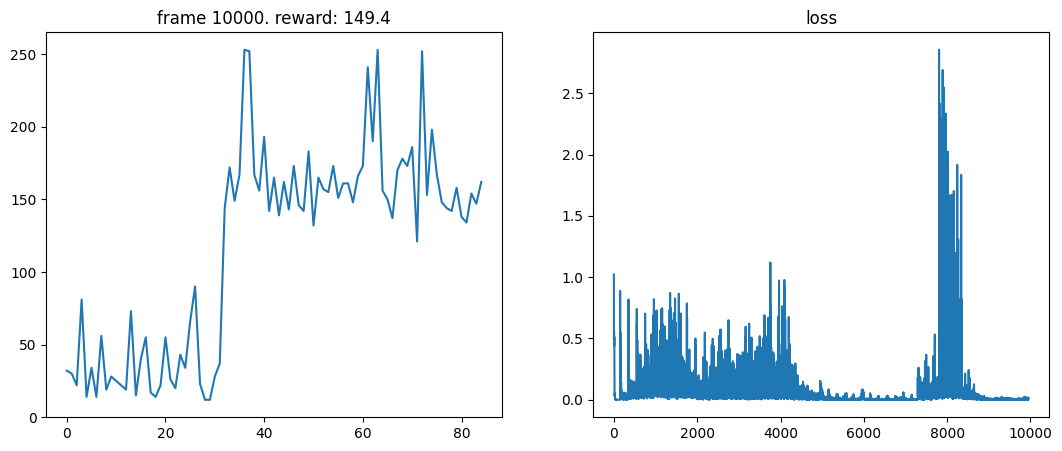

Game video of final agent shown above, the accumulated reward is: 309


In [ ]:
# Below is the main training procedure of deep Q-learning
# Please go over each line and tune the hyperparameters for satisfied performance
replay_buffer = ReplayBuffer(1000)  # clear the buffer
## student code here
num_frames =  10000                            # Suggested range: 2000 - 10000
batch_size =  50                                 # Suggested range: 8 - 128
GAMMA      =  0.95                           # Suggested range: >0.9
NETWORK_UPDATE_PERIOD = 200                      # Suggested range: 50 - 300
# student code end


losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for i in range(100000):
    action = choose_action(state, 0)
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()
show_video()
print('Game video of initial agent shown above, the accumulated reward is:', i)

print('Training in progress ...')
state = env.reset()
for frame_idx in tqdm(range(1, num_frames + 1)):
    epsilon = epsilon_by_frame(frame_idx)
    action = choose_action(state, epsilon)                  # pick action
    next_state, reward, done, _ = env.step(action)          # interact with environment
    replay_buffer.push(state, action, reward, next_state, done) # store experience
    
    state = next_state
    episode_reward += reward
    
    if done:                                                        # restart the game
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:                             # start training
        loss = compute_td_loss(batch_size, GAMMA)
        losses.append(loss.cpu().data.numpy())

    if frame_idx % NETWORK_UPDATE_PERIOD == 0:                      # update target network using eval network
        update_target(eval_model, target_model)

plot(frame_idx, all_rewards, losses)
state = env.reset()
for i in range(100000):
    action = choose_action(state, 0)
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()
show_video()
print('Game video of final agent shown above, the accumulated reward is:', i)

**Task 9:** After implementing the double DQN, we are interested in hearing about any interesting findings or observations you may have made. This could include insights into key hyperparameters, effective improving mechanisms, or any other subject that you found particularly interesting.

To receive full credit for this open-ended question, we ask that you provide a detailed discussion supported by persuasive data or experimental results. This could include comparisons between different hyperparameters, experiments demonstrating the effectiveness of specific techniques, or analyses of the impact of different factors on the performance of the model.